In [1]:
using Pkg
pkg"activate ."
pkg"instantiate"
pkg"precompile"

  Updating registry at `C:\Users\Chiyoung Ahn\.julia\registries\General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
Precompiling project...


In [ ]:
using PerlaTonettiWaugh, Plots, BenchmarkTools, CSV

In [3]:
gr(fmt = :png)

Plots.GRBackend()

# Steady states

## Solving steady state solutions

Set up parameters and find the corresponding stationary solution:

Below are the results from the **updated** matlab calibration with the corresponding letters. Here I added the $\mu$ parameter in the calibration routine to fit the firm dynamic moments. Fit improved a lot and it generated a negative drift term which is what we need to keep S from going negative.


In [4]:
# NEW CALIBRATION

parameters = parameter_defaults()

parameters = merge(parameters, (ρ = 0.0215, d = 3.0426 , θ = 5.0018  ,  κ = 0.0732, χ = 1/5.9577, υ =  0.0484 , μ = -0.0189, σ = 3.1725, δ = 0.02,))

(ρ = 0.0215, σ = 3.1725, N = 10, θ = 5.0018, γ = 1.0, κ = 0.0732, ζ = 1.0, η = 0.0, Theta = 1, χ = 0.1678500092317505, υ = 0.0484, μ = -0.0189, δ = 0.02, d = 3.0426)

In [5]:
parameters.δ

0.02

In [6]:
changed_parameters = false # set this to true if you drastically change the parameters

true

Side note on previous version. Essentially, under this calibration, the parameters are very simmilar. Theta, chi, kappa are quite close to what we had in the prior version.

In [7]:
# Define common objects. 
#parameters = parameter_defaults()

settings = settings_defaults()
settings = merge(settings, (transition_penalty_coefficient = 1.0, ))

settings = merge(settings, (z_ex = unique([range(0., 0.1, length = 40)' range(0.1, 1., length = 40)' range(1., 5, length = 100)']),))
settings = merge(settings, (z = settings.z_ex[2:end-1], ))

P = length(settings.z)

d_0 = parameters.d # Here is the 10 percent tariff increase
d_T = 1 + (parameters.d-1)*0.90

d_autarky = 1 + (parameters.d-1)*2.5 

params_0 = merge(parameters, (d = d_0, )) # parameters to be used at t = 0
params_T = merge(parameters, (d = d_T, )) # parameters to be used at t = T
params_autarky = merge(parameters, (d = d_autarky, )) # parameters to be used in autarky calc

# initial value for numerical solver on (g, z_hat, Omega)
initial_x = [0.02; 2; .57]

# solve for stationary solution at t = 0
stationary_sol_0 = stationary_algebraic(params_0, initial_x) # solution at t = 0
stationary_sol = stationary_algebraic(params_T, initial_x) # solution at t = T
stationary_autarky = stationary_algebraic(params_autarky, initial_x) # solution at t = T

Ω_0 = stationary_sol_0.Ω;
Ω_T = stationary_sol.Ω;

In [8]:
d_0

3.0426

In [9]:
print(stationary_sol.U_bar,'\n') 
print(stationary_sol_0.U_bar,'\n')
print(stationary_sol_0.S,'\n')
print(stationary_autarky.S,'\n')

19.536172711003402
16.106813814683527
0.0989517579364377
0.07742571652180796


In [10]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")
print("SS to SS welfare gain: ", stationary_sol.λ_ii,"\n")

SS to SS welfare gain: 7.6517416240797775
SS to SS welfare gain: 0.8574023485038085


In [11]:
print("SS to SS welfare gain: ", stationary_sol.g,"\n")

SS to SS welfare gain: 0.008570416914745884


### This is the autarky calculation

In [12]:
#T = solved.t[end]
lambda_ss_autarky = 100*(consumption_equivalent(stationary_autarky.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss_autarky,"\n")
print("Autarky Home Share, should be close to 1: ", stationary_autarky.λ_ii,"\n")
print("Autarky TFP growth rate ", stationary_autarky.g,"\n")

SS to SS welfare gain: -15.522308452599521
Autarky Home Share, should be close to 1: 0.9965183434231
Autarky TFP growth rate 0.00243807896292438


## Welfare in Steady States

### Steady state at `T`

In [13]:
stationary_sol.U_bar

19.536172711003402

### Steady state at `0`

In [14]:
stationary_sol_0.U_bar

16.106813814683527

### Outstanding Issue \#1: Sensitivity of growth to trade.

This is a big difference relative to previous version. As noted above, with parameter values that are quite similar to what we had before, the growth rate is changing a lot with only a very small change in trade flows. Why?

In [15]:
@show stationary_sol.g, stationary_sol_0.g;

(stationary_sol.g, stationary_sol_0.g) = (0.008570416914745884, 0.0067417379286226755)


---

# Transition dynamics

Setup for optimizer:

In [16]:
settings = merge(settings, (params_T = params_T, stationary_sol_T = stationary_numerical(params_T, settings.z_ex), Ω_0 = Ω_0, T = 150.0));

Use the solution found with calibrated parameters above for `E`

In [17]:
settings = merge(settings, (transition_x0 = [-0.998254873760952, -0.5060923510363916, -0.4009880494240544, -0.25390133944298543, -0.18503794333490725, -0.1394414958616132, -0.09688480053528754, -0.09605464209945933, -0.06698882334951167, -0.052006470880313516, -0.05077464721268157, -0.019275295630678396, -0.018107744362588774, -0.011818732601638654, -0.006814206563344461], 
        tstops = (changed_parameters ? nothing : 1:settings.T),
        weights = [10.0; ones(24)])); # remove tstops when solving the model for the first time to get a rough solution first

Find the corresponding solution

In [49]:
@time result = solve_full_model(merge(settings, (transition_iterations = (changed_parameters ? 10000 : 0),)); 
    impose_E_monotonicity_constraints = true, write_data = false, datadir = nothing,
    run_global = changed_parameters)

solved = result.solution;
E_nodes = result.E_nodes;
solved = solved.results;

Starting optimization with optimizer BlackBoxOptim.DiffEvoOpt{BlackBoxOptim.FitPopulation{Float64},BlackBoxOptim.RadiusLimitedSelector,BlackBoxOptim.AdaptiveDiffEvoRandBin{3},BlackBoxOptim.RandomBound{BlackBoxOptim.RangePerDimSearchSpace}}
0.00 secs, 0 evals, 0 steps
0.56 secs, 10 evals, 6 steps, improv/step: 1.000 (last = 1.0000), fitness=0.685502355
1.08 secs, 23 evals, 13 steps, improv/step: 1.000 (last = 1.0000), fitness=0.674951819
1.62 secs, 37 evals, 21 steps, improv/step: 0.905 (last = 0.7500), fitness=0.577139138
2.18 secs, 52 evals, 29 steps, improv/step: 0.931 (last = 1.0000), fitness=0.577139138
2.68 secs, 65 evals, 37 steps, improv/step: 0.919 (last = 0.8750), fitness=0.577139138
3.21 secs, 79 evals, 48 steps, improv/step: 0.813 (last = 0.4545), fitness=0.527579367
3.75 secs, 93 evals, 59 steps, improv/step: 0.746 (last = 0.4545), fitness=0.524641015
4.28 secs, 107 evals, 70 steps, improv/step: 0.729 (last = 0.6364), fitness=0.434942918
4.79 secs, 119 evals, 79 steps, impr

47.53 secs, 1015 evals, 965 steps, improv/step: 0.491 (last = 0.3636), fitness=0.000178403
48.03 secs, 1025 evals, 975 steps, improv/step: 0.489 (last = 0.3000), fitness=0.000178403
48.54 secs, 1035 evals, 985 steps, improv/step: 0.485 (last = 0.1000), fitness=0.000178403
49.04 secs, 1045 evals, 995 steps, improv/step: 0.482 (last = 0.2000), fitness=0.000178403
49.57 secs, 1055 evals, 1005 steps, improv/step: 0.482 (last = 0.4000), fitness=0.000178403
50.11 secs, 1066 evals, 1016 steps, improv/step: 0.484 (last = 0.7273), fitness=0.000178403
50.62 secs, 1076 evals, 1026 steps, improv/step: 0.481 (last = 0.1000), fitness=0.000178403
51.19 secs, 1085 evals, 1035 steps, improv/step: 0.480 (last = 0.4444), fitness=0.000178403
51.70 secs, 1094 evals, 1044 steps, improv/step: 0.477 (last = 0.1111), fitness=0.000178403
52.23 secs, 1103 evals, 1053 steps, improv/step: 0.475 (last = 0.2222), fitness=0.000178403
52.78 secs, 1113 evals, 1063 steps, improv/step: 0.472 (last = 0.2000), fitness=0.00

95.26 secs, 1854 evals, 1804 steps, improv/step: 0.370 (last = 0.2500), fitness=0.000061473
95.79 secs, 1862 evals, 1812 steps, improv/step: 0.369 (last = 0.2500), fitness=0.000061473
96.32 secs, 1871 evals, 1821 steps, improv/step: 0.368 (last = 0.2222), fitness=0.000061473
96.83 secs, 1878 evals, 1828 steps, improv/step: 0.368 (last = 0.2857), fitness=0.000061473
97.35 secs, 1887 evals, 1837 steps, improv/step: 0.366 (last = 0.0000), fitness=0.000061473
97.88 secs, 1896 evals, 1846 steps, improv/step: 0.365 (last = 0.1111), fitness=0.000061473
98.44 secs, 1906 evals, 1856 steps, improv/step: 0.364 (last = 0.1000), fitness=0.000061473
99.00 secs, 1915 evals, 1865 steps, improv/step: 0.362 (last = 0.1111), fitness=0.000061473
99.55 secs, 1924 evals, 1874 steps, improv/step: 0.362 (last = 0.2222), fitness=0.000061473
100.08 secs, 1933 evals, 1883 steps, improv/step: 0.361 (last = 0.2222), fitness=0.000061473
100.61 secs, 1943 evals, 1893 steps, improv/step: 0.360 (last = 0.1000), fitnes

142.57 secs, 2639 evals, 2589 steps, improv/step: 0.295 (last = 0.5000), fitness=0.000028826
143.14 secs, 2647 evals, 2597 steps, improv/step: 0.294 (last = 0.0000), fitness=0.000028826
143.74 secs, 2655 evals, 2605 steps, improv/step: 0.294 (last = 0.2500), fitness=0.000028826
144.27 secs, 2664 evals, 2614 steps, improv/step: 0.294 (last = 0.2222), fitness=0.000028826
144.79 secs, 2673 evals, 2623 steps, improv/step: 0.293 (last = 0.1111), fitness=0.000028826
145.31 secs, 2681 evals, 2631 steps, improv/step: 0.293 (last = 0.1250), fitness=0.000028826
145.81 secs, 2689 evals, 2639 steps, improv/step: 0.293 (last = 0.2500), fitness=0.000028496
146.36 secs, 2698 evals, 2648 steps, improv/step: 0.292 (last = 0.1111), fitness=0.000028496
146.90 secs, 2707 evals, 2657 steps, improv/step: 0.291 (last = 0.1111), fitness=0.000028496
147.41 secs, 2715 evals, 2665 steps, improv/step: 0.290 (last = 0.0000), fitness=0.000028496
147.97 secs, 2724 evals, 2674 steps, improv/step: 0.290 (last = 0.2222

189.96 secs, 3405 evals, 3355 steps, improv/step: 0.248 (last = 0.2500), fitness=0.000008634
190.52 secs, 3414 evals, 3364 steps, improv/step: 0.249 (last = 0.3333), fitness=0.000008634
191.08 secs, 3423 evals, 3373 steps, improv/step: 0.248 (last = 0.0000), fitness=0.000008634
191.63 secs, 3432 evals, 3382 steps, improv/step: 0.248 (last = 0.2222), fitness=0.000008634
192.19 secs, 3441 evals, 3391 steps, improv/step: 0.247 (last = 0.1111), fitness=0.000008634
192.73 secs, 3450 evals, 3400 steps, improv/step: 0.247 (last = 0.1111), fitness=0.000008634
193.26 secs, 3458 evals, 3408 steps, improv/step: 0.246 (last = 0.0000), fitness=0.000008634
193.81 secs, 3467 evals, 3417 steps, improv/step: 0.246 (last = 0.0000), fitness=0.000008634
194.37 secs, 3476 evals, 3426 steps, improv/step: 0.246 (last = 0.2222), fitness=0.000008634
194.89 secs, 3485 evals, 3435 steps, improv/step: 0.245 (last = 0.0000), fitness=0.000008634
195.45 secs, 3494 evals, 3444 steps, improv/step: 0.245 (last = 0.1111

284.93 secs, 4924 evals, 4874 steps, improv/step: 0.197 (last = 0.1250), fitness=0.000003005
285.47 secs, 4933 evals, 4883 steps, improv/step: 0.197 (last = 0.2222), fitness=0.000003005
286.03 secs, 4942 evals, 4892 steps, improv/step: 0.197 (last = 0.1111), fitness=0.000003005
286.59 secs, 4950 evals, 4900 steps, improv/step: 0.197 (last = 0.1250), fitness=0.000003005
287.15 secs, 4959 evals, 4909 steps, improv/step: 0.196 (last = 0.0000), fitness=0.000003005
287.65 secs, 4967 evals, 4917 steps, improv/step: 0.196 (last = 0.0000), fitness=0.000003005
288.18 secs, 4976 evals, 4926 steps, improv/step: 0.195 (last = 0.0000), fitness=0.000003005
288.72 secs, 4985 evals, 4935 steps, improv/step: 0.196 (last = 0.2222), fitness=0.000003005
289.27 secs, 4994 evals, 4944 steps, improv/step: 0.195 (last = 0.1111), fitness=0.000003005
289.81 secs, 5003 evals, 4953 steps, improv/step: 0.195 (last = 0.0000), fitness=0.000003005
290.36 secs, 5011 evals, 4961 steps, improv/step: 0.195 (last = 0.2500

332.69 secs, 5691 evals, 5641 steps, improv/step: 0.180 (last = 0.0000), fitness=0.000003005
333.20 secs, 5699 evals, 5649 steps, improv/step: 0.180 (last = 0.1250), fitness=0.000003005
333.74 secs, 5708 evals, 5658 steps, improv/step: 0.179 (last = 0.0000), fitness=0.000003005
334.25 secs, 5716 evals, 5666 steps, improv/step: 0.179 (last = 0.1250), fitness=0.000003005
334.75 secs, 5724 evals, 5674 steps, improv/step: 0.179 (last = 0.0000), fitness=0.000003005
335.27 secs, 5731 evals, 5681 steps, improv/step: 0.179 (last = 0.1429), fitness=0.000003005
335.79 secs, 5740 evals, 5690 steps, improv/step: 0.179 (last = 0.0000), fitness=0.000003005
336.33 secs, 5749 evals, 5699 steps, improv/step: 0.178 (last = 0.1111), fitness=0.000003005
336.85 secs, 5758 evals, 5708 steps, improv/step: 0.178 (last = 0.0000), fitness=0.000003005
337.37 secs, 5767 evals, 5717 steps, improv/step: 0.178 (last = 0.0000), fitness=0.000003005
337.89 secs, 5776 evals, 5726 steps, improv/step: 0.178 (last = 0.0000

380.31 secs, 6464 evals, 6414 steps, improv/step: 0.164 (last = 0.0000), fitness=0.000001759
380.83 secs, 6472 evals, 6422 steps, improv/step: 0.164 (last = 0.0000), fitness=0.000001759
381.38 secs, 6481 evals, 6431 steps, improv/step: 0.164 (last = 0.1111), fitness=0.000001243
381.92 secs, 6490 evals, 6440 steps, improv/step: 0.163 (last = 0.0000), fitness=0.000001243
382.42 secs, 6498 evals, 6448 steps, improv/step: 0.163 (last = 0.0000), fitness=0.000001243
382.93 secs, 6506 evals, 6456 steps, improv/step: 0.163 (last = 0.0000), fitness=0.000001243
383.45 secs, 6514 evals, 6464 steps, improv/step: 0.163 (last = 0.0000), fitness=0.000001243
384.00 secs, 6523 evals, 6473 steps, improv/step: 0.163 (last = 0.1111), fitness=0.000001243
384.56 secs, 6532 evals, 6482 steps, improv/step: 0.162 (last = 0.0000), fitness=0.000001243
385.11 secs, 6541 evals, 6491 steps, improv/step: 0.162 (last = 0.0000), fitness=0.000001243
385.65 secs, 6550 evals, 6500 steps, improv/step: 0.162 (last = 0.0000

474.73 secs, 7906 evals, 7856 steps, improv/step: 0.141 (last = 0.0000), fitness=0.000000370
475.23 secs, 7914 evals, 7864 steps, improv/step: 0.141 (last = 0.0000), fitness=0.000000370
475.75 secs, 7920 evals, 7870 steps, improv/step: 0.141 (last = 0.0000), fitness=0.000000370
476.26 secs, 7928 evals, 7878 steps, improv/step: 0.141 (last = 0.0000), fitness=0.000000370
476.79 secs, 7937 evals, 7887 steps, improv/step: 0.141 (last = 0.0000), fitness=0.000000370
477.30 secs, 7945 evals, 7895 steps, improv/step: 0.140 (last = 0.0000), fitness=0.000000370
477.85 secs, 7953 evals, 7903 steps, improv/step: 0.140 (last = 0.0000), fitness=0.000000370
478.36 secs, 7961 evals, 7911 steps, improv/step: 0.140 (last = 0.0000), fitness=0.000000370
478.87 secs, 7969 evals, 7919 steps, improv/step: 0.140 (last = 0.0000), fitness=0.000000370
479.38 secs, 7977 evals, 7927 steps, improv/step: 0.140 (last = 0.0000), fitness=0.000000370
479.90 secs, 7984 evals, 7934 steps, improv/step: 0.140 (last = 0.1429

521.69 secs, 8606 evals, 8556 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
522.26 secs, 8614 evals, 8564 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
522.82 secs, 8622 evals, 8572 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
523.34 secs, 8629 evals, 8579 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
523.87 secs, 8637 evals, 8587 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
524.43 secs, 8645 evals, 8595 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
524.95 secs, 8653 evals, 8603 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
525.46 secs, 8660 evals, 8610 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
525.97 secs, 8668 evals, 8618 steps, improv/step: 0.131 (last = 0.0000), fitness=0.000000370
526.53 secs, 8676 evals, 8626 steps, improv/step: 0.131 (last = 0.1250), fitness=0.000000370
527.07 secs, 8684 evals, 8634 steps, improv/step: 0.130 (last = 0.0000

569.07 secs, 9325 evals, 9275 steps, improv/step: 0.124 (last = 0.0000), fitness=0.000000370
569.61 secs, 9334 evals, 9284 steps, improv/step: 0.124 (last = 0.0000), fitness=0.000000370
570.16 secs, 9343 evals, 9293 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
570.68 secs, 9351 evals, 9301 steps, improv/step: 0.124 (last = 0.2500), fitness=0.000000370
571.21 secs, 9360 evals, 9310 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
571.77 secs, 9369 evals, 9319 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
572.28 secs, 9377 evals, 9327 steps, improv/step: 0.123 (last = 0.1250), fitness=0.000000370
572.79 secs, 9385 evals, 9335 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
573.33 secs, 9394 evals, 9344 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
573.89 secs, 9403 evals, 9353 steps, improv/step: 0.123 (last = 0.0000), fitness=0.000000370
574.44 secs, 9412 evals, 9362 steps, improv/step: 0.123 (last = 0.0000

616.57 secs, 10037 evals, 9987 steps, improv/step: 0.116 (last = 0.0000), fitness=0.000000370
617.13 secs, 10046 evals, 9996 steps, improv/step: 0.116 (last = 0.0000), fitness=0.000000370

Optimization stopped after 10001 steps and 617.4700000286102 seconds
Termination reason: Max number of steps (10000) reached
Steps per second = 16.196738302324984
Function evals per second = 16.277713896277213
Improvements/step = 0.1157
Total function evaluations = 10051


Best candidate found: [-0.977219, -0.539421, -0.124888, -0.0601259, -0.0528164, -0.0271418, -0.0137457, -0.00480982, -0.00219537, -0.000923478, -0.000407592, -0.000395912, -0.000339499, -7.20788e-5, -2.21238e-5]

Fitness: 0.000000370

1083.876398 seconds (8.39 G allocations: 1.474 TiB, 12.66% gc time)


---
## Welfare Gains

In [51]:
print("Utility in initial SS: ", stationary_sol_0.U_bar,"\n")
print("Utility in new SS: ", stationary_sol.U_bar,"\n")

Utility in initial SS: 16.106813814683527
Utility in new SS: 19.536172711003402


In [52]:
print("Utility immediately after change ", solved.U[1],"\n")

Utility immediately after change 12.27967574255424


#### Summary so far...

In the old paper, what we did was take U_0_ss at some date t, then compare it to U_ss at the same date t. This is like an instantaneous jump to the new ss. This is what the first cell is looking at and note that this is like a 17 percent increase in utility. Higher than what we had in the paper, but in of the same order of magnitude. 

The next cell reprots the utility just after the change. Utility here includes the future path of consumption and change in growth rate, so it "bakes in" the transition path. Here it goes up by much more than utility in the new SS. This is what I was expecting given the dynamics of consumption. 

In [53]:
solved.r[100] + 0.05

stationary_sol_0.r

0.04824173792862267

Just a reminder about how the function `counsumption_equivalent(U_new, U_old, parameters)` works, it takes U_new and then U_old in that order, then evaluates the **gross** increase in consumption. 100 times this value **minus one** gives the permanent, percent increase in consumption required to make the agent indifferent between the two paths. 

In [54]:
#T = solved.t[end]
lambda_ss = 100*(consumption_equivalent(stationary_sol.U_bar, stationary_sol_0.U_bar, parameters)-1)

print("SS to SS welfare gain: ", lambda_ss,"\n")

SS to SS welfare gain: 7.6517416240797775


In [55]:
lambda_tpath = 100*(consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)-1)

print("Inclusive of the Transition Path: ", lambda_tpath,"\n")

Inclusive of the Transition Path: -7.898915592001754


### Relative to initial notebook computations

- SS to SS, the issue here is that we should compare **at date 0** utility in the first ss vs. the second ss. This is what we must have been doing in the previous version of the paper. The previous calulation in the old notebook had 
```consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)```
which took **date T** utility and compard them. The problem is that this now depends on date T. So if we picked T to be arbitraily large, then utility will be arbitraily different.

- Following the same logic, the transition path should compare **date 0** utility with the initial value from the transition path. So what we want to do is to compare everything at 0. In the previous calculation, we had
```consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)```
were comparing the initial utility relative to ss utility on the old path at date T. So the initial blue point below versues the last orange dashed point. **See the figure below**

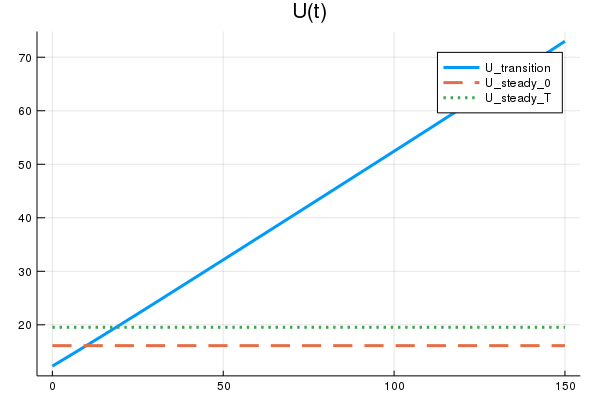

In [56]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

### Outstanding Issue \#2: Welfare Gains still depend on T in transition path.

The stuff above I think is correct, the one issue is why does the welfare gains, inclusive of the transition path seem to depend on T??? So change T above from 40 to 75 or 100, then the welfare gains fall alot? Why?

---
## Plotting

In [57]:
solved.U[end]

72.98874245071877

## Plots for Ω and residuals

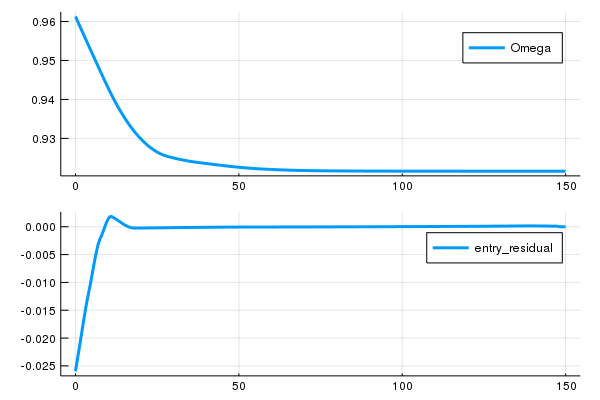

In [58]:
#solved = solved.results;
plot_Ω = plot(solved.t, solved.Ω, label = "Omega", lw = 3)
plot_residual = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot_Ω, plot_residual, layout = (2,1))

## Primary Plots

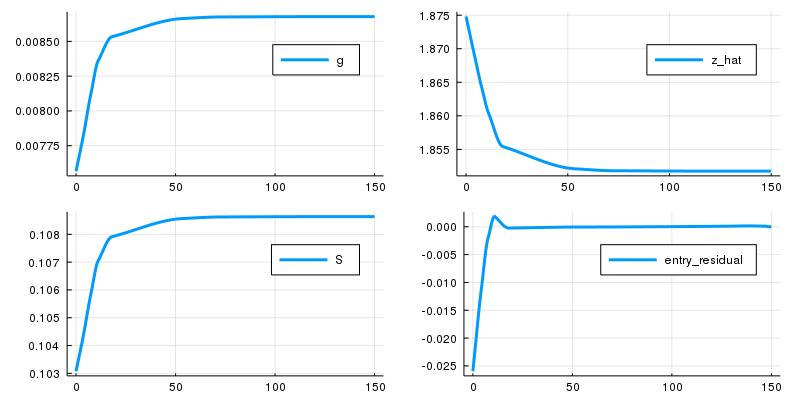

In [59]:
plot1 = plot(solved.t, solved.g, label = "g", lw = 3)
plot2 = plot(solved.t, solved.z_hat, label = "z_hat", lw = 3)
plot3 = plot(solved.t, solved.S, label = "S", lw = 3)
plot4 = plot(solved.t, solved.entry_residual, label = "entry_residual", lw = 3)
plot(plot1, plot2, plot3, plot4, layout=(2,2), size = (800, 400))

## Static Equations

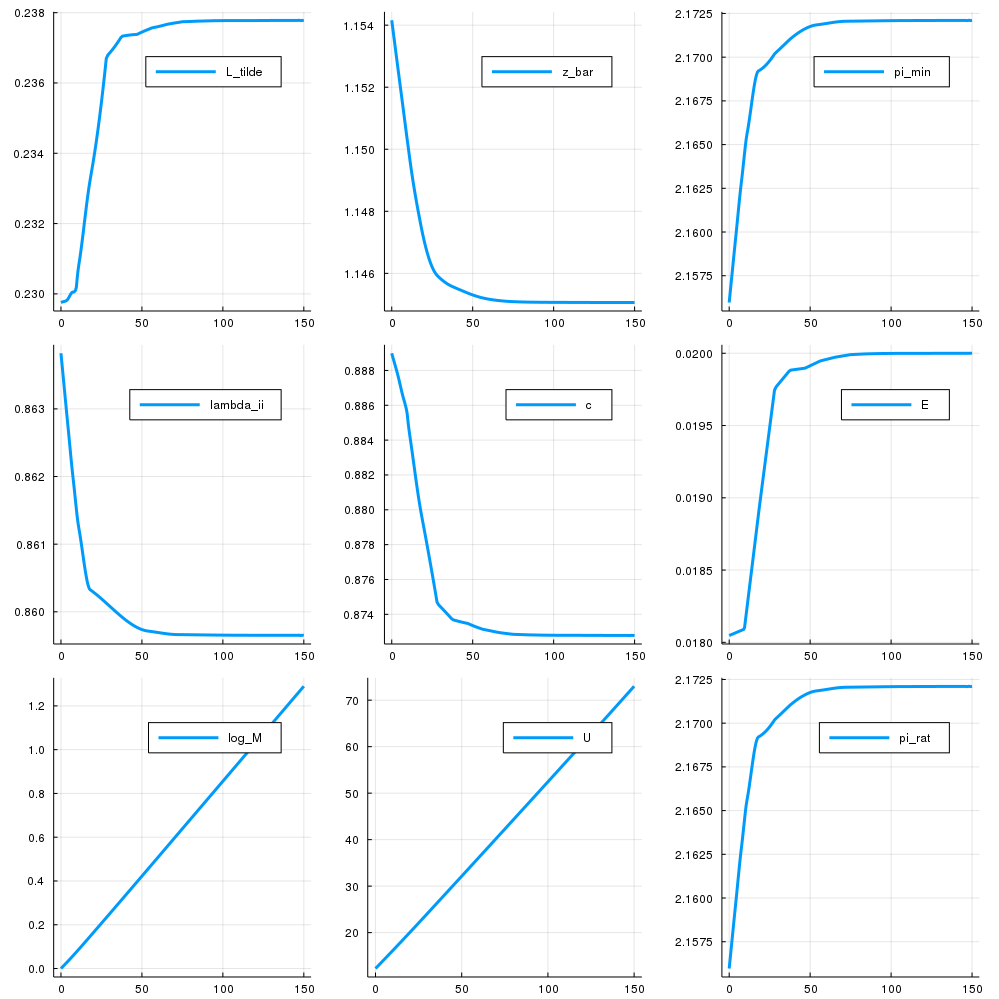

In [60]:
plot1 = plot(solved.t, solved.L_tilde, label = "L_tilde", lw = 3)
plot2 = plot(solved.t, solved.z_bar, label = "z_bar", lw = 3)
plot3 = plot(solved.t, solved.π_rat, label = "pi_min", lw = 3)
plot4 = plot(solved.t, solved.λ_ii, label = "lambda_ii", lw = 3)
plot5 = plot(solved.t, solved.c, label = "c", lw = 3)
plot6 = plot(solved.t, solved.E, label = "E", lw = 3)
plot7 = plot(solved.t, solved.log_M, label = "log_M", lw = 3)
plot8 = plot(solved.t, solved.U, label = "U", lw = 3)
plot9 = plot(solved.t, solved.π_rat, label = "pi_rat", lw = 3)
plot(plot1, plot2, plot3, plot4, plot5, plot6, plot7, plot8, plot9, layout=(3,3), size = (1000, 1000))

# Welfare analysis

### `log_M(t)`

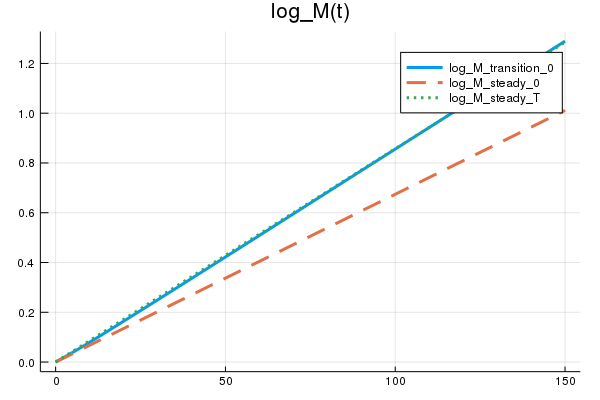

In [61]:
# define log_M with steady state g
log_M_steady_0(t) = stationary_sol_0.g * t
log_M_steady_T(t) = stationary_sol.g * t

# generate the plot!
plot(solved.t, 
    [solved.log_M, log_M_steady_0, log_M_steady_T], 
    label = ["log_M_transition_0", "log_M_steady_0", "log_M_steady_T"] ,
    title = "log_M(t)", linestyle = :auto, lw = 3)

### `Ω(t)`

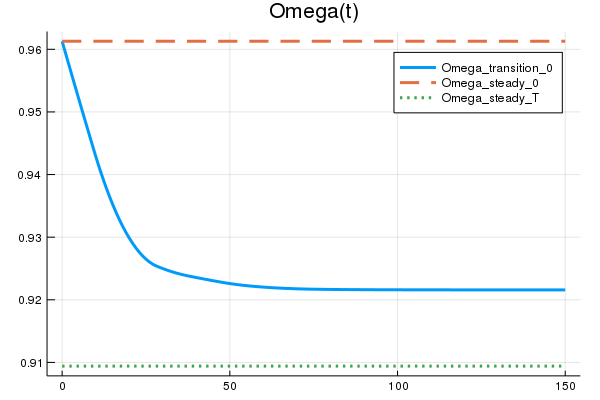

In [62]:
# define Ω function (constant)
Ω_steady_0(t) = stationary_sol_0.Ω
Ω_steady_T(t) = stationary_sol.Ω

# generate the plot!
plot(solved.t, 
    [solved.Ω, Ω_steady_0, Ω_steady_T], 
    label = ["Omega_transition_0", "Omega_steady_0", "Omega_steady_T"] ,
    title = "Omega(t)", linestyle = :auto, lw = 3)

### `c(t)`

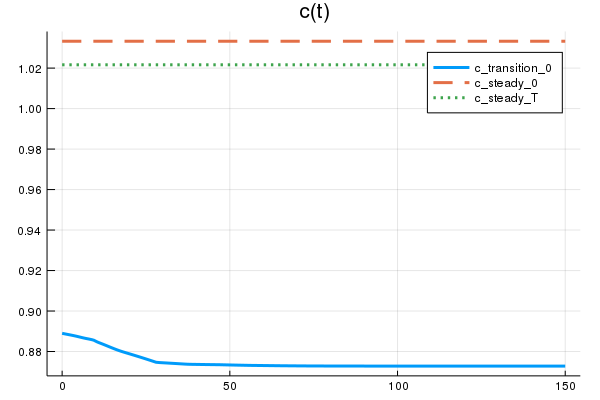

In [63]:
# define c function (constant)
c_steady_0(t) = stationary_sol_0.c
c_steady_T(t) = stationary_sol.c

# generate the plot!
plot(solved.t, 
    [solved.c, c_steady_0, c_steady_T], 
    label = ["c_transition_0", "c_steady_0", "c_steady_T"] ,
    title = "c(t)", linestyle = :auto, lw = 3)

### `U(t)`

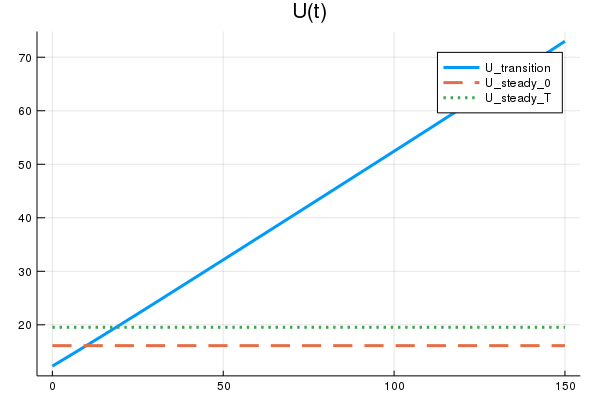

In [64]:
# generate the plot!
U_steady_0(t) = stationary_sol_0.U_bar
U_steady_T(t) = stationary_sol.U_bar

plot(solved.t, 
    [solved.U, U_steady_0, U_steady_T], 
    label = ["U_transition", "U_steady_0", "U_steady_T"] ,
    title = "U(t)", linestyle = :auto, lw = 3)

## Consumption equivalent for search threshold (`M(0)`)
See computational appendix for details.

### `M(0)` by two steady states (autarky and steady state at `T`)

In [65]:
T = solved.t[end]
consumption_equivalent(solved.U[end], stationary_sol_0.U_bar, parameters)

3.397233641792408

### `M(0)` by autarky and transition from `t=0`

In [66]:
T = solved.t[end]
consumption_equivalent(solved.U[1], stationary_sol_0.U_bar, parameters)

0.9210108440799825

But if we include the transition path, this falls a lot. Like down to 13 percent gain. 

In [67]:
# solved 
# Run the above to see the whole dataframe

In [68]:
using DataFrames

df_stationary = DataFrame(t = -1.00, g =stationary_sol_0.g, λ_ii = stationary_sol_0.λ_ii, c = stationary_sol_0.c, L_tilde = stationary_sol_0.L_tilde, Ω = stationary_sol_0.Ω,
    π_rat = stationary_sol_0.π_rat, L_tilde_a = stationary_sol_0.L_tilde_a, L_tilde_x = stationary_sol_0.L_tilde_x, 
    L_tilde_E= stationary_sol_0.L_tilde_E, r = stationary_sol_0.r);

In [69]:
CSV.write("stationary_results.csv", df_stationary)

"stationary_results.csv"

In [70]:
df_transition = DataFrame(t = solved.t, g =solved.g, λ_ii = solved.λ_ii, c = solved.c, L_tilde = solved.L_tilde, Ω = solved.Ω,
    π_rat = solved.π_rat, L_tilde_a = solved.L_tilde_a, L_tilde_x = solved.L_tilde_x,
    L_tilde_E= solved.L_tilde_E, r = solved.r .+ parameters.δ);

In [71]:
CSV.write("transition_results.csv", df_transition)

"transition_results.csv"

In [72]:
stationary_sol_0.π_rat

1.8110075391436142

In [73]:
df_welfare = DataFrame(steady_state = lambda_ss, transition_path = lambda_tpath, growth_rate = stationary_sol.g, theta = parameters.θ);
CSV.write("welfare_results.csv", df_welfare)

"welfare_results.csv"

In [74]:
df_autarky = DataFrame(steady_state = lambda_ss_autarky, growth_rate = stationary_autarky.g, theta = parameters.θ);
CSV.write("autarky_welfare_results.csv", df_autarky)

"autarky_welfare_results.csv"

### R and W

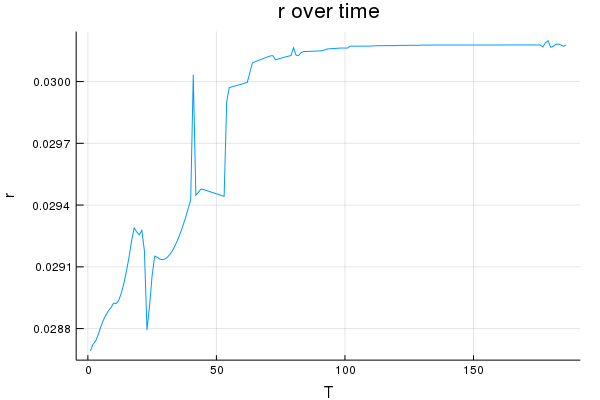

In [75]:
plot(solved.r, legend = false, title = "r over time", xlabel = "T", ylabel = "r")

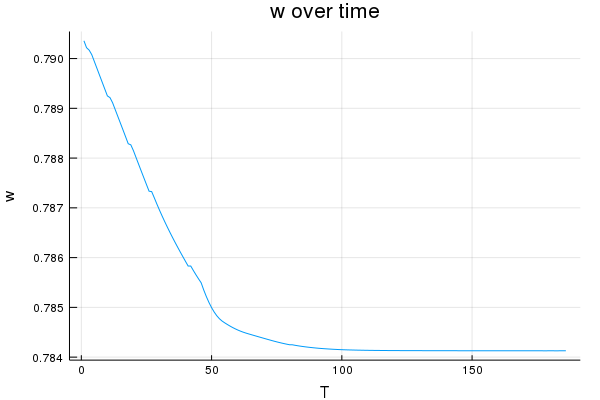

In [76]:
plot(solved.w, legend = false, title = "w over time", xlabel = "T", ylabel = "w")

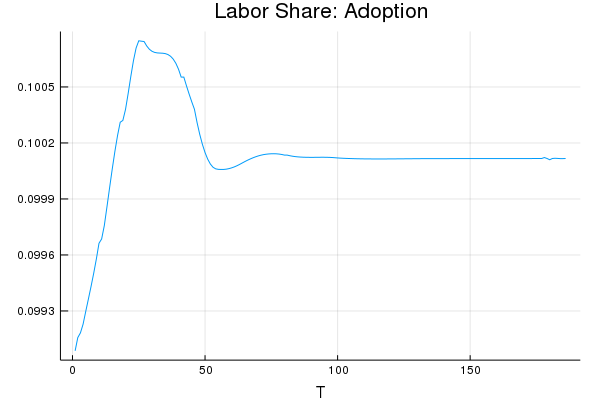

In [77]:
plot(solved.L_tilde_a, legend = false, xlabel = "T", title = "Labor Share: Adoption")

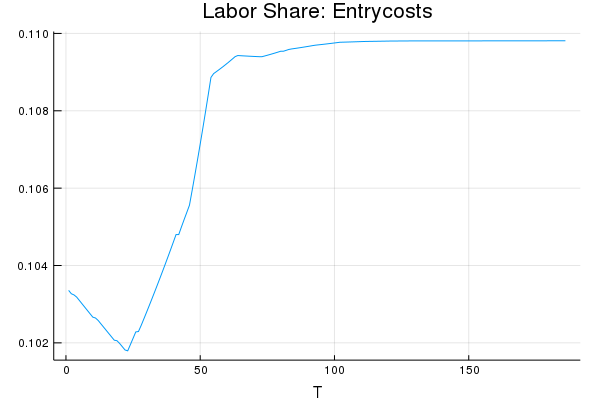

In [78]:
plot(solved.L_tilde_E, legend = false, xlabel = "T", title = "Labor Share: Entrycosts")

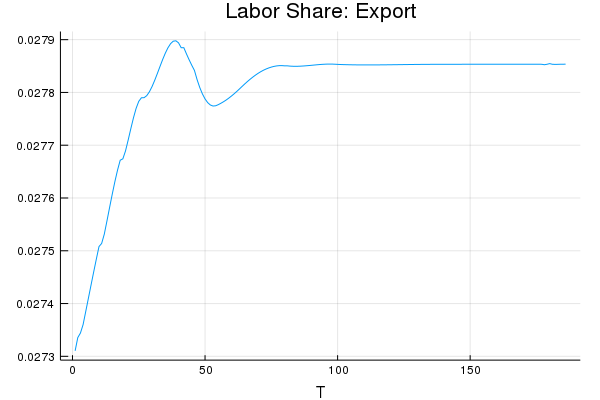

In [79]:
plot(solved.L_tilde_x, legend = false, xlabel = "T", title = "Labor Share: Export")